In [1]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

D:\python\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
d_ms = pd.read_csv('../example_data/clustering/sample0815.csv')

In [3]:
d_ms.head()

,Average Rt(min),Average Mz,S/N average,20180815_CEC_CAL-8-no4_MSpos_1,20180815_CEC_CAL-8-no4_MSpos_2,20180815_CEC_CAL-8-no4_MSpos_3,20180815_CEC_CAL-8-no4_MSpos_4,20180815_CEC_CAL-8-no4_MSpos_5,20180815_CEC_CAL-8-no4_MSpos_6,20180815_CEC_CAL-8-no4_MSpos_7,...,20180815_SR520-Creek_Mix6A_3,20180815_SR520-Creek_Mix6B_1,20180815_SR520-Creek_Mix6B_2,20180815_SR520-Creek_Mix6B_3,20180815_Swan-Creek-Dec_1,20180815_Swan-Creek-Dec_2,20180815_Swan-Creek-Dec_3,20180815_Swan-Creek-May_1,20180815_Swan-Creek-May_2,20180815_Swan-Creek-May_3
0,8.273,100.03867,40.44,0,0,88,0,0,89,0,...,238,113,184,202,0,0,0,0,76,0
1,8.304,100.03956,77.03,0,0,88,0,0,88,0,...,238,217,184,202,0,0,0,0,73,0
2,7.097,100.07603,52.53,64,231,104,247,259,145,294,...,1375,1139,511,1159,1201,1337,1723,573,2585,1585
3,5.226,100.11173,31.39,1629,882,1850,2217,1254,946,1095,...,18206,20583,20713,19942,21409,21764,23078,18056,18226,17470
4,4.944,100.11175,14.70,759,934,396,1676,583,639,336,...,10508,8889,14385,6274,12796,14584,13262,7576,12092,11060


In [4]:
d_ms = d_ms.rename(columns={'Average Rt(min)': 'Average RT (min)', 'Average Mz': 'Average m/z', 'S/N average': 'Average sn'})
d_ms.insert(3, "Average score", 1)

In [5]:
def d_clean(dataframe, rt_range=[0, 30], mz_range=[0, 1200], sn_thres=3, score_thres=0, area_thres=5000): #Update with *args or **args in future updates
    #Area thres update
    drop_index = np.argwhere(np.asarray(dataframe[dataframe.columns[4:]].max(axis=1)) < area_thres).reshape(1,-1)
    df_c = dataframe.drop(drop_index[0])
    
    df_c = df_c[(df_c['Average RT (min)'] > rt_range[0]) & (df_c['Average RT (min)'] < rt_range[1])]
    df_c = df_c[(df_c['Average m/z'] > mz_range[0]) & (df_c['Average m/z'] < mz_range[1])]
    df_c = df_c[df_c['Average sn'] >= sn_thres]
    df_c = df_c[df_c['Average score'] >= score_thres]
    df_c.reset_index(inplace=True)
    df_c.drop(columns=['index'],inplace=True)
    
    return df_c

In [6]:
df_c = d_clean(d_ms,rt_range = [1,30], mz_range = [200,800], area_thres=500)

In [7]:
#Distinguish between sample and blank
col_blank = [col for col in df_c.columns if 'CEC' in col or 'Blank' in col or 'ISTD' in col or 'Wash' in col or 'Shutdown' in col]
col_sample = [col for col in df_c.columns if col not in col_blank]

In [8]:
#sample vs blank threshold
samplevsblank_thres = 10
d_sample = df_c[df_c[col_sample[4:]].max(axis=1) / df_c[col_blank].mean(axis=1) > samplevsblank_thres][col_sample]
d_sample.reset_index(inplace=True)
d_sample.drop(columns=['index'],inplace=True)

In [9]:
#Noise removal from triplicates
trip_list = [list(i) for j, i in groupby(d_sample.columns[4:], lambda a: a.split('_')[1])] #Needs to define 1. parser 2. position of parsing

In [10]:
empty_tol = 0
cv_tol = 5

for triplicate in tqdm(trip_list):
    for index, row in d_sample[triplicate].iterrows():
        if (row == 0).sum() > empty_tol:
            d_sample.loc[index, triplicate] = 0
            #Filling the gaps and check variance? --- coefficient of variation
        elif row.std() / row.mean() > mvm_tol:
            d_sample.loc[index, triplicate] = 0 #If delete or reduce all number to avg?

100%|██████████| 9/9 [02:21<00:00, 15.67s/it]


In [10]:
#Double check if any empty columns and clean up
d_sample = d_sample[(d_sample.iloc[:,4:]!=0).sum(1) > 3]

In [11]:
#visualization
#Normalization to 0 1 scale
c_data=d_sample[4:].values #returns a numpy array
#Normalized to absolute values
c_norm = []
for row in c_data:
    c_norm.append(row/max(row))
c_norm = np.asarray(c_norm)
#Normalized to relative values
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(c_data.T)
# df=pd.DataFrame(x_scaled)
d_norm = pd.DataFrame(c_norm)

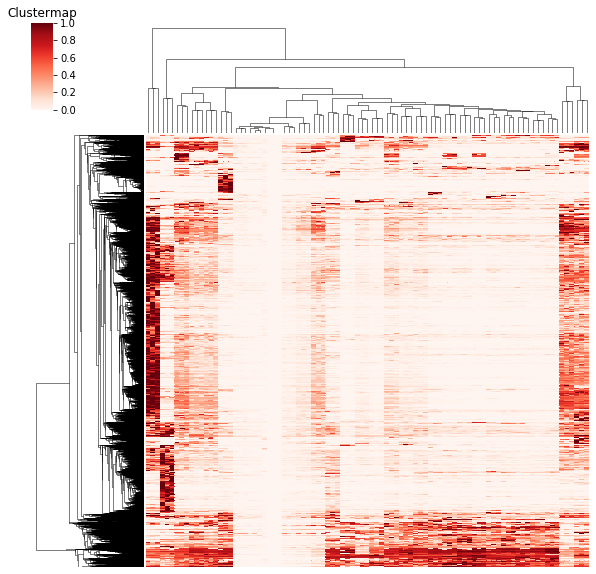

In [12]:
#no 0 is acceptable in the clustermap -- eye balling estimation?
sns.clustermap(d_norm.values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False)
plt.title('Clustermap')
plt.show()

# whole batch or only dilution series
whole batch to start with the testing, then apply extra filter to filter out cases, one exist both in source and non-source sample and etc.

In [13]:
#normalization of the dataset for statistical analysis -- unsupervised machine learning
#Q: is the normalization needed to terminate the effect of peak area variation?
#option: random forest, som, pca+k-means， t-sne+dbscan, autoencoder
#option2: non-parametric test
#Normalized data-c_data
d_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,0.000035,0.001665,0.000153,8.320921e-06,0.027093,0.031536,0.007888,0.018747,0.010751,0.007897,...,0.008005,0.029781,0.026103,0.015643,0.010659,0.023299,0.017565,0.008363,0.009752,0.009270
1,0.000065,0.002977,0.000216,1.487652e-05,0.031419,0.022940,0.030913,0.018432,0.009670,0.047783,...,0.015115,0.020678,0.008048,0.027031,0.009580,0.011767,0.006501,0.007825,0.012318,0.012719
2,0.000132,0.005159,0.000152,2.577652e-05,0.036319,0.028535,0.045728,0.025158,0.044387,0.021858,...,0.037943,0.070937,0.035752,0.029463,0.006238,0.014667,0.018662,0.032633,0.022477,0.029540
3,0.000004,0.000138,0.000100,6.873197e-07,0.000910,0.001241,0.001043,0.001507,0.000728,0.002008,...,0.002420,0.003483,0.005568,0.004246,0.001081,0.001783,0.003248,0.002019,0.001278,0.001489
4,0.000221,0.009102,0.000597,4.546281e-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031869,0.012502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# clustering general idea
1. directly use high demensional data to do the clustering
2. reduce dimension to 2/3 dimensional data use t-sne/pca/som and etc, then do the clustering using dbscan or other clustering techniques

In [14]:
#PCA -- other transformation is needed
from sklearn.preprocessing import StandardScaler
df_pca=d_sample.iloc[:,4:]
x = df_pca.values
# Standardizing the features
x = StandardScaler().fit_transform(x)

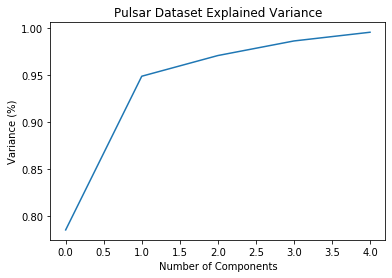

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x) #X : array-like, shape (n_samples, n_features)

# Plotting the Cumulative Sum of the Explained Variance, use explained variance to choose number of principle componenets
# you may choose number of componenets that explained > 99% variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [20]:
(pca.explained_variance_ratio_).cumsum()

array([0.78495832, 0.94903259, 0.97110997, 0.9866875 , 0.99598908])

In [21]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-0.373304,0.052295
1,-0.360529,0.059731
2,-0.357528,0.025405
3,-0.360193,0.023667
4,-0.343193,0.014078


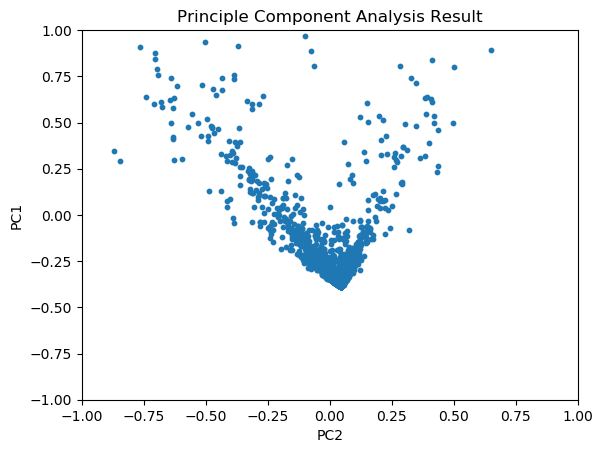

In [34]:
plt.style.use('default')
finalDf = principalDf
principle_1 = finalDf.loc[:,'principal component 1']
principle_2 = finalDf.loc[:,'principal component 2']
n = list(df_pca.columns)

fig, ax = plt.subplots()
ax.scatter(principle_2, principle_1, s=10)
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title('Principle Component Analysis Result')
plt.xlim(-1,1)
plt.ylim(-1,1)


    
plt.show()

In [36]:
#HCA https://www.kaggle.com/fazilbtopal/popular-unsupervised-clustering-algorithms
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

In [37]:
dist = distance_matrix(d_norm, d_norm)
print(dist)

[[0.         1.17586778 1.37348648 ... 2.11537392 3.40801972 3.756548  ]
 [1.17586778 0.         0.76031069 ... 1.8940158  3.20156639 3.64394988]
 [1.37348648 0.76031069 0.         ... 1.90943833 3.14536406 3.56814174]
 ...
 [2.11537392 1.8940158  1.90943833 ... 0.         2.92960476 3.16741683]
 [3.40801972 3.20156639 3.14536406 ... 2.92960476 0.         2.49806954]
 [3.756548   3.64394988 3.56814174 ... 3.16741683 2.49806954 0.        ]]


In [38]:
Z = hierarchy.linkage(dist, 'complete') #Check function documentation to choose the better method
#single, complete, average, weighted, centroid, median, ward

D:\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


In [41]:
#Not so good
# plt.figure(figsize=(18, 50))
# dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size=12, orientation='right')

In [42]:
#average linkage works somehow better, still need to verify and trails
# Z = hierarchy.linkage(dist, 'average')
# plt.figure(figsize=(18, 50))
# dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

In [15]:
#https://easyai.tech/blog/unsupervised-learning-with-python/
#TSNE clustering -- using lower demension to model for high demension data
from sklearn.manifold import TSNE

In [92]:
model = TSNE(learning_rate=100,perplexity=30,n_iter=1000) #Tune perplexity and n_iter
transformed = model.fit_transform(d_norm)

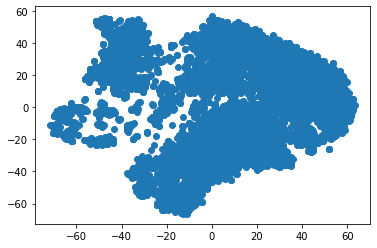

In [93]:
x = transformed[:,0]
y = transformed[:,1]
plt.scatter(x, y)
plt.show()

In [14]:
#DBSCAN -- coupled with t-sne?
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs

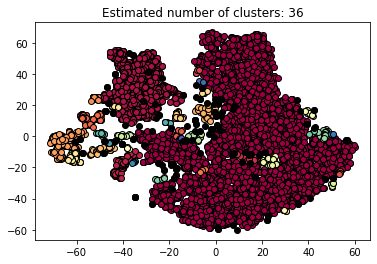

In [38]:
X=transformed
db = DBSCAN(eps=2, min_samples=5).fit(X) #eps=0.3, min_samples=10
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k')

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k')

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Non-para testing ideas -- hypothesis testing
similar to alignment, compare row to row trend/statistical difference and then assign neighbours as same group

In [76]:
data1 = d_norm.iloc[1]
data2 = d_norm.iloc[500]

In [77]:
#Pearson’s Correlation Coefficient
from scipy.stats import pearsonr
count = 1
stat, p = pearsonr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    count += 1
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.825, p=0.000
Probably dependent


In [78]:
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.679, p=0.000
Probably dependent


In [79]:
# Example of the Kendall's Rank Correlation Test
from scipy.stats import kendalltau
stat, p = kendalltau(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.506, p=0.000
Probably dependent


In [81]:
# Example of the Chi-Squared Test
from scipy.stats import chi2_contingency
table = [data1,data2]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=3.351, p=1.000
Probably independent


In [82]:
# Example of the Mann-Whitney U Test --check for distribution
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=2369.500, p=0.000
Probably different distributions


In [83]:
# Example of the Kruskal-Wallis H Test
from scipy.stats import kruskal
stat, p = kruskal(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=24.836, p=0.000
Probably different distributions


In [ ]:
#comparison plot -- different algorithm with clustering result as color label in the mz/rt scatter plot
#Post filter--some cpd show up in dilution but not other samples, and vice versa
#Prediction model based on clustering information